In [1]:
# Her importeres Point og Daily funksjonalitetene fra meteostat modulen.
# Hvis meteostat ikke allerede er installert blir den installert.
try:
  import meteostat
except:
  !pip install meteostat
  import meteostat

In [2]:
# Her importeres modulen pandas som pd sammen med numpy og matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import  scipy.stats

In [3]:
# Her importeres funksjonaliteten datetime fra modulen datetime.
# Datetime gir oss en bekvem måte å jobbe med tidsdate på.

from datetime import datetime, timedelta

In [4]:
# Sett tidsperioden vi vil hente data fra
# Data for fremtiden kan ikke lastes inn, så når vi ber om å laste inn data får vi data helt opp til i dag.

start = datetime(1973, 1, 1)
end = datetime(2024, 12, 31)

In [5]:
# Målestasjon Florida Bergen
data = meteostat.Daily('01317', start, end)
data = data.fetch()
data = data.ffill()

In [6]:
# setter endedato til å være siste dag vi har data for
end = data.index[-1]

In [7]:
data_årlig = pd.DataFrame(index=data.index)

In [8]:
data_årlig = pd.DataFrame(data['tavg'].groupby(data.index.year).mean())

In [9]:
#Vi leser inn tiden talt i dager fra første måling
t = (np.array(data_årlig.index) - np.array(data_årlig.index)[0]).astype(np.timedelta64(1, 'Y')).astype(float)[:, None]

In [10]:
y = data_årlig['tavg'].values[:, None].astype(float)

In [11]:
A = np.ones((t.size, 2))
A[:, 0] = t[:, 0]

In [12]:
# Hjelpestørrelser for analytisk beregning av av regresjonslinje

Ey = np.mean(y)
Eyt = np.mean(y * t)
Et = np.mean(t)
Ett = np.mean(t * t)

Husk: $x_1 = \frac{E(\mathbf{y}\mathbf{t}) - E(\mathbf{t})E(\mathbf{y})}{E(\mathbf{t}^2) - E(\mathbf{t})^2}$
og $x_2 = E(\mathbf{y}) - x_1E(\mathbf{t})$

In [13]:
# Beregner heldning og hvor regresjonslinje krysser y-aksen
xx1 = (Eyt - Et * Ey)/(Ett - Et * Et)
xx2 = Ey - xx1 * Et

# Legger x1 og x2 inn i en vektor
xx = np.array([[xx1],[xx2]])

# Beregner regresjonslinjen
L= xx1 * t + xx2

In [14]:
# Legger regresjonslinjen inn i pandas dataframe
data_årlig['L'] = L

<Axes: xlabel='time'>

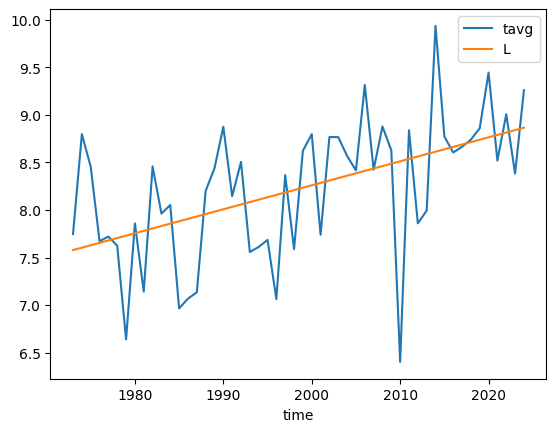

In [15]:
data_årlig.plot(y=['tavg', 'L'])

In [16]:
data_årlig['lineært_residual'] = data_årlig['L'] - data_årlig['tavg']

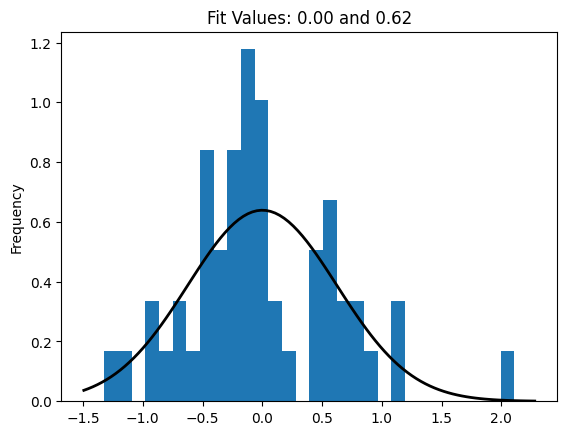

In [17]:
mu, std = scipy.stats.norm.fit(data_årlig['lineært_residual'])
data_årlig['lineært_residual'].plot(kind='hist', bins=30, density=True)
range = np.arange(-10, 10, 0.01)
# plt.plot(range, norm.pdf(range,0,4))
xmin, xmax = plt.xlim()
plt.plot(np.linspace(xmin, xmax, 100), scipy.stats.norm.pdf(np.linspace(xmin, xmax, 100), mu, std), 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title);

**Det ser tvilsomt ut!**

## Test av stigningstall i regresjon

Standardavviket for estimeringen av $x_1$ kan tilnærmes med formelen:

$$\sigma(x_1(\mathbf{t},\mathbf{y})) =\frac{ 1}{\sqrt{n}\ \sigma(\mathbf{t})}  \sqrt{\frac{\operatorname{SSR(L, \mathbf{t}, \mathbf{y}})}{n-2}} $$

Hvor
$$\operatorname{SSR(L, \mathbf{t}, \mathbf{y}}) = (y_1 - L(t_1))^2 + \dots + (y_n - L(t_n))^2$$
og
$\sigma(\mathbf{t})^2 = E(\mathbf{t}^2) - E(\mathbf{t})^2$.


$t$-verdien for hypotesen om at det underliggende stigningstallet $x_1$ er lik $\widetilde x_1$ er gitt ved formelen
$$t = \frac{x_1(\mathbf{t},\mathbf{y}) - \widetilde x_1}{\sigma(x_1(\mathbf{t},\mathbf{y}))}.$$

Antallet av frihetsgrader er $n$ minus antall parametre som estimeres. Vi estimerer parametrene $x_1$ og $x_2$, så
antallet av frihetsgrader er $n - 2$.

Vi er nå klar til å avgjøre om nullhypotesen vår skal forkastes:

Vi kan se på $x_1$ som en funksjon av $t$-verdien:

$$x_1 = x_1(\mathbf{t},\mathbf{y})  - t  {\sigma(x_1(\mathbf{t},\mathbf{y}))}.$$

In [18]:
x1tilde = 1 / 40
SSR_av_L_t_y = np.sum((y - L)**2)

In [19]:
sigmaxx1 = (np.sqrt(SSR_av_L_t_y / (len(y) - 2)) / (np.sqrt(len(y)) * np.std(t)))
t_verdi = (xx1 - x1tilde)/(sigmaxx1)

In [20]:
antall_frihetsgrader = len(y) - 2

In [21]:
t_verdi

np.float64(0.03461226472075047)

Teorien for normalfordelte observasjoner forutsier at $t$-verdien vi nettopp beregnet vil fordele seg etter en $t$-fordeling med $n-2$ frihetsgrader.

$t$-fordelingen er tilnærmet lik normalfordelingen med standardavvik $1$ og gjennomsnitt $0$ når antallet av frihetsgrader er stort.

## Overgang fra t-verdi til sannsynlighet, eller p-verdi

Vi antar at temperaturen $y$ er fordelt etter en normalfordeling med gjennomsnittsverdi $\mu$ og standardavvik $\sigma$.

Gitt en $t$-verdien $t\_\text{verdi}$ og antallet av frihetsgrader kan vi finne sannsynligheten for at $\mu \le \mu_0$ og sannsynligheten for at $\mu > \mu_0$.

Hvis sannsynligheten for nullhypotesen $H_0$: $\mu \le \mu_0$ er veldig liten velger vi å forkaste nullhypotesen. 

Vi må på forhånd bestemme oss for hva vi mener med veldig liten. 

Et typisk valg er "mindre en 5%".

I vårt tilfelle er $t\_\text{verdi}$ og antall frihetsgrader gitt ved:

In [22]:
# t-verdi og antall frihetsgrader

sigmay = np.std(y)
antall_frihetsgrader = len(y) - 2
float(t_verdi), antall_frihetsgrader

(0.03461226472075047, 50)

Arealet til det røde området på figuren under er sannsynligheten for at nullhypotesen er sann.

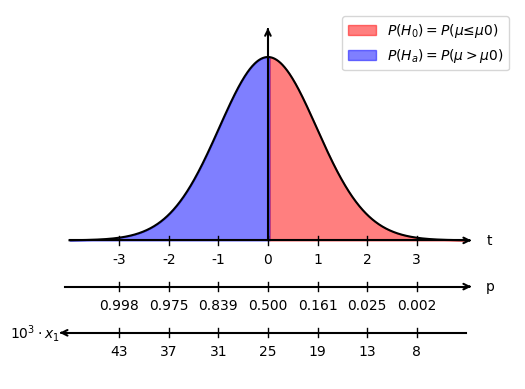

In [23]:
# @title plot
import matplotlib.pyplot as plt
import numpy as np

# Define the function
x = np.linspace(-4, 4, 1000)
yy = scipy.stats.t.pdf(x, antall_frihetsgrader)  # t-fordeling med 10 frihetsgrader
t_crit = t_verdi

def t_av_mu(m):
    return (xx1 - m)/(sigmaxx1)

def mu_av_t(t):
    return xx1 - t*sigmaxx1

ax = plt.gca()

plt.plot(x, yy, color='black')
plt.fill_between(x, yy, where=(x > t_crit), color='red', alpha=0.5, label=r'$P(H_0)=P(μ≤μ0)$')
plt.fill_between(x, yy, where=(x < t_crit), color='blue', alpha=0.5, label=r'$P(H_a)=P(μ>μ0)$')
# Remove default spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Set limits
ax.set_xlim(-5, 5)
ax.set_ylim(-.3, .5)  # Ensure axes are visible

# Draw the primary x-axis (for x) with an arrow
ax.plot([-4, 4], [0, 0], color="black", lw=1.5)  
ax.annotate("", xy=(4.1, 0), xytext=(4., 0),
            arrowprops=dict(arrowstyle="->", lw=1.5), annotation_clip=False)
ax.text(4.4, 0, r"t", verticalalignment="center")

# Draw the secondary x-axis (for -x) with an arrow
ax.plot([-4.1, 4], [-.1, -.1], color="black", lw=1.5)  
ax.annotate("", xy=(4.1, -.1), xytext=(4., -.1),
            arrowprops=dict(arrowstyle="->", lw=1.5), annotation_clip=False)
ax.text(4.4, -.1, r"p", verticalalignment="center")

# Draw the third x-axis (for -x) with an arrow
ax.plot([-4.1, 4], [-.2, -.2], color="black", lw=1.5)  
ax.annotate("", xy=(-4.2, -.2), xytext=(-4.1, -.2),
            arrowprops=dict(arrowstyle="->", lw=1.5), annotation_clip=False)
ax.text(-5.2, -.2, r"$10^3 \cdot x_1$", verticalalignment="center")

# Draw the y-axis with an arrow
ax.plot([0, 0], [0, .45], color="black", lw=1.5)  
ax.annotate("", xy=(0, .46), xytext=(0, .45),
            arrowprops=dict(arrowstyle="->", lw=1.5), annotation_clip=False)
#ax.text(-0.3, .45, r"y", verticalalignment="center")


# Set x-ticks for t-axis
ticks = np.arange(-3, 4, 1)  # Tick positions

# Draw ticks for t-axis
for ti in ticks:
    ax.plot([ti, ti], [-.01, .01], color="black", lw=1)  # Small tick marks
    ax.text(ti, -.05, f"{ti}", fontsize=10, ha="center")  # Labels below ticks

# Draw ticks for p-axis
for ti in ticks:
    p = scipy.stats.t.cdf(-ti, antall_frihetsgrader)
    ax.plot([ti, ti], [-.11, -.09], color="black", lw=1)  # Small tick marks
    ax.text(ti, -.15, f"{p:.3f}", fontsize=10, ha="center")  # Labels below ticks

# Set ticks for μ-axis
# mu_verdier = np.arange(0.9, 1.5, .1)
# muticks = [t_av_mu(mu) for mu in mu_verdier]
# # muticks = [mu_av_t(t) for t in ticks]
# # Draw ticks for secondary x-axis (-x)
# for t, mu in zip(muticks, mu_verdier):
#     ax.plot([t, t], [-.21, -.19], color="black", lw=1)  # Small tick marks
#     ax.text(t, -.25, f"{mu:.2f}", fontsize=10, ha="center")  # Labels below ticks
for ti in ticks:    
    ax.plot([ti, ti], [-.21, -.19], color="black", lw=1)  # Small tick marks
    ax.text(ti, -.25, f"{int(100000*mu_av_t(ti))/100:.0f}", fontsize=10, ha="center")  # Labels below ticks

# Remove y-ticks
ax.set_yticks([])
ax.set_xticks([])
plt.legend()
plt.show()


Nullhypotesen $x_1 = \widetilde x_1$ forkastes når sannsynligheten for alternativ hypotese $H_1$: $x_1 > \widetilde x_1$ er minst $95 \%$. Det er det samme som at sannsynligheten for $H_0$ er høyst $5 \%$.

I gitt fall sier vi at nullhypotesen forkastes med $5 \%$ signifikansnivå.

Som for normalfordelingen kan scipy hjelpe oss med å finne dette arealet:

In [24]:
# p-verdi
1 - scipy.stats.t.cdf(t_verdi, df=antall_frihetsgrader)

np.float64(0.4862633664278899)

In [25]:
# Siden t-funksjonen er symmetrisk fås samme verdi ved å integrere frem til -t_verdi
p_verdi = scipy.stats.t.cdf(-t_verdi, antall_frihetsgrader)

In [26]:
#vi får p-verdien

float(100 * p_verdi)

48.626336642789006

Vi kan **forkaste** nullhypotesen som sier at temperaturen i Bergen ikke er steget med mere enn en grad celsius med et signifikansnivå på 5%.

**Konklusjon:**

Vi formoter om temperaturen i Bergen er steget med mere enn en grad per 40 år.

## Oppgave

Hva hadde p-verdien blitt hvis vi testet på om temperaturen i Bergen er steget med mere enn en **halv** grad per 40 år.